In [9]:

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
df = pd.read_csv('level3.csv')

In [65]:
# MOA map for labels
meta_map = pd.read_csv('repurposing_info_external_moa_map_resolved.tsv', sep='\t')
meta_map = meta_map[['broad_sample', 'moa']]

In [4]:
def feats(df):
    features_ = []
    for col in df.columns.tolist():
        if col.startswith('efficientnet_'):
            features_.append(col)
    return features_

In [5]:
features = feats(df)
meta_features = []
for col in df.columns.tolist():
    if col.startswith('Metadata_'):
        meta_features.append(col)

In [6]:
# add MOA metadata
df = pd.merge(df, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])

In [7]:
df = df.sort_values(by=['Metadata_Plate', 'Metadata_Well'])

In [34]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[features].values)
df['pca_one'] = pca_result[:,0]
df['pca_two'] = pca_result[:,1]
df['pca_three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.55793103 0.13111339 0.06018347]


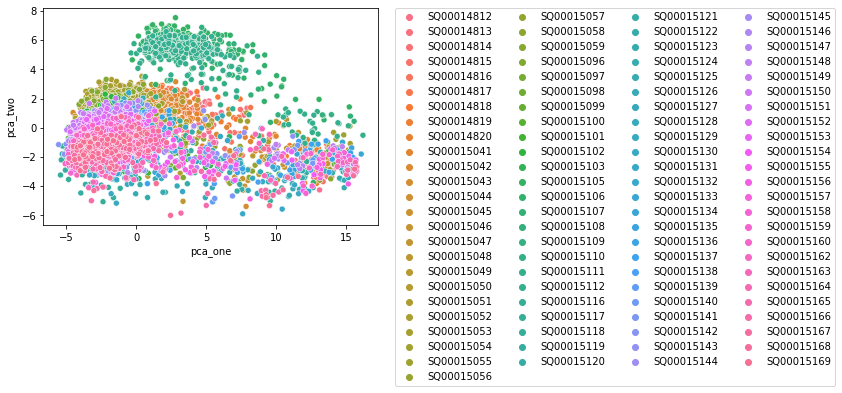

In [44]:
gfg = sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='Metadata_Plate')
plt.style.use({'figure.facecolor':'white'})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

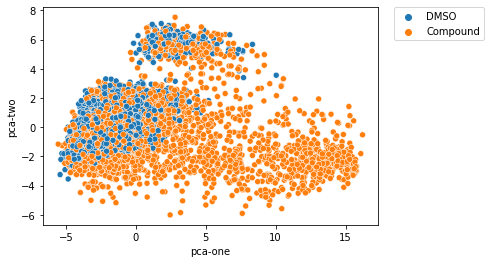

In [18]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 'DMSO'
    else:
        return 'Compound'
df['DMSO'] = df.Metadata_broad_sample.apply(is_dmso)
gfg = sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='DMSO', sizes=3)
plt.style.use({'figure.facecolor':'white'})
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

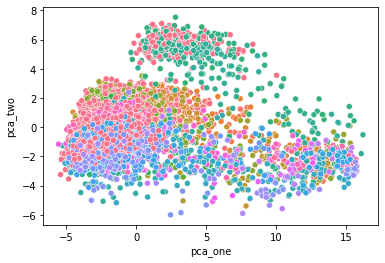

In [62]:
gfg = sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='Metadata_broad_sample', sizes=3)
plt.style.use({'figure.facecolor':'white'})
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
gfg.legend_.remove()

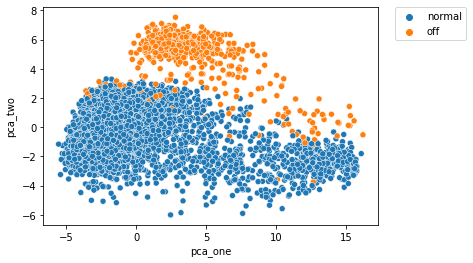

In [38]:
# 'SQ00015103',
off_plates = ['SQ00015052', 'SQ00015105', 'SQ00015106', 'SQ00015107',
       'SQ00015108', 'SQ00015109', 'SQ00015110', 'SQ00015111',
       'SQ00015112']
def is_off(plate):
    if plate in off_plates:
        return 'off'
    else:
        return 'normal'
df['off'] = df.Metadata_Plate.apply(is_off)
gfg = sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='off', sizes=3)
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.style.use({'figure.facecolor':'white'})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

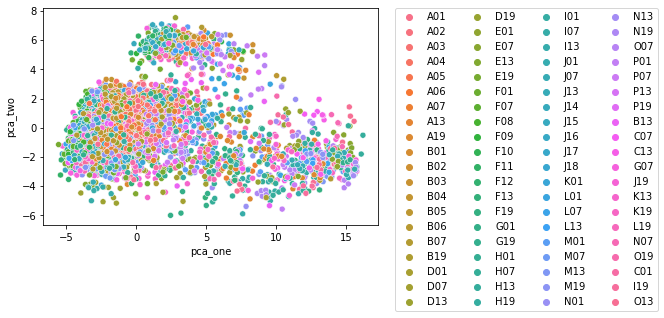

In [43]:
gfg = sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='Metadata_Well', sizes=3)
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.style.use({'figure.facecolor':'white'})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

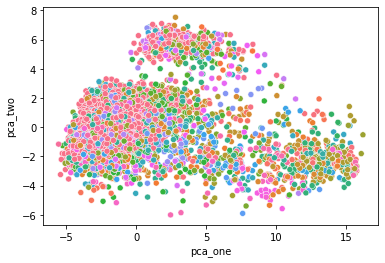

In [56]:
gfg = sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='Metadata_moa', sizes=3)
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.style.use({'figure.facecolor':'white'})
gfg.legend_.remove()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

array(['SQ00015052', 'SQ00015105', 'SQ00015106', 'SQ00015107',
       'SQ00015108', 'SQ00015109', 'SQ00015110', 'SQ00015111',
       'SQ00015112'], dtype=object)

In [45]:
rob_DMSO = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
)

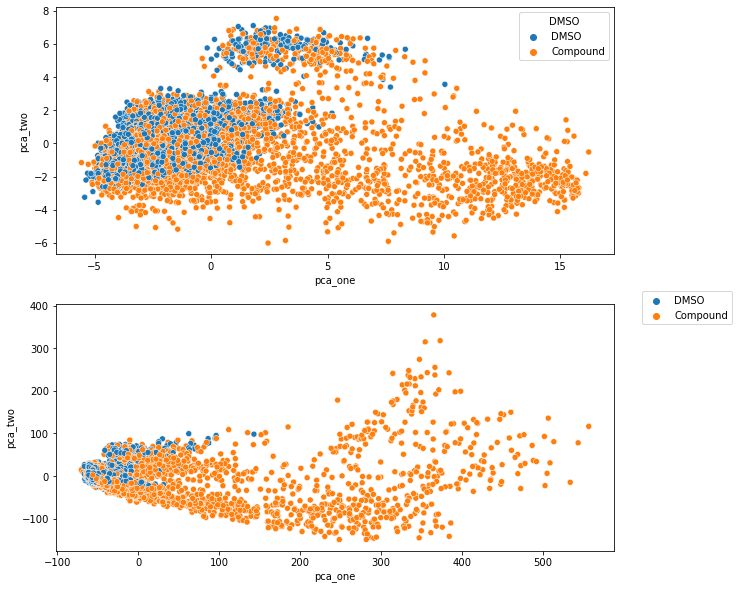

In [58]:
rob_DMSO['DMSO'] = rob_DMSO.Metadata_broad_sample.apply(is_dmso)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rob_DMSO[features].values)
rob_DMSO['pca_one'] = pca_result[:,0]
rob_DMSO['pca_two'] = pca_result[:,1]

fig, ax =plt.subplots(2,1, figsize=(10,10))
gfg = sns.scatterplot(data=rob_DMSO, x="pca_one", y='pca_two', hue='DMSO', sizes=3, ax=ax[1])
sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='DMSO', sizes=3, ax=ax[0])
plt.style.use({'figure.facecolor':'white'})
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)

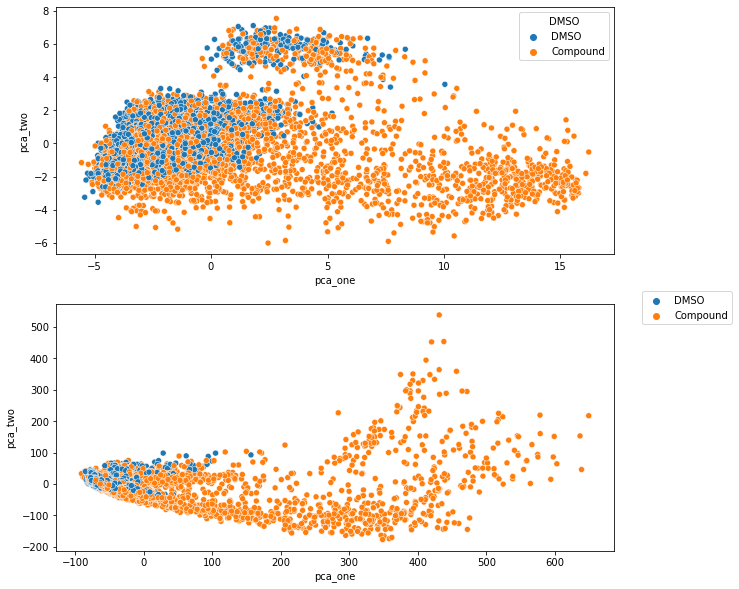

In [59]:
stand_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='standardize',
    output_file='none'
)
stand_dmso['DMSO'] = stand_dmso.Metadata_broad_sample.apply(is_dmso)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(stand_dmso[features].values)
stand_dmso['pca_one'] = pca_result[:,0]
stand_dmso['pca_two'] = pca_result[:,1]

fig, ax =plt.subplots(2,1, figsize=(10,10))
gfg = sns.scatterplot(data=stand_dmso, x="pca_one", y='pca_two', hue='DMSO', sizes=3, ax=ax[1])
sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='DMSO', sizes=3, ax=ax[0])
plt.style.use({'figure.facecolor':'white'})
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)




In [66]:
con = aggregate(
    df,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])

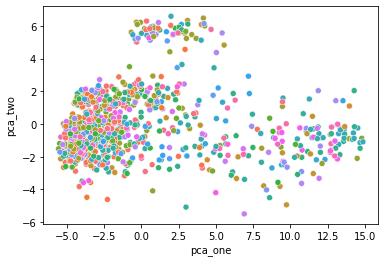

In [69]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(con[features].values)
con['pca_one'] = pca_result[:,0]
con['pca_two'] = pca_result[:,1]

gfg = sns.scatterplot(data=con, x="pca_one", y='pca_two', hue='moa')
plt.style.use({'figure.facecolor':'white'})
gfg.legend_.remove()

In [70]:
sphere = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)

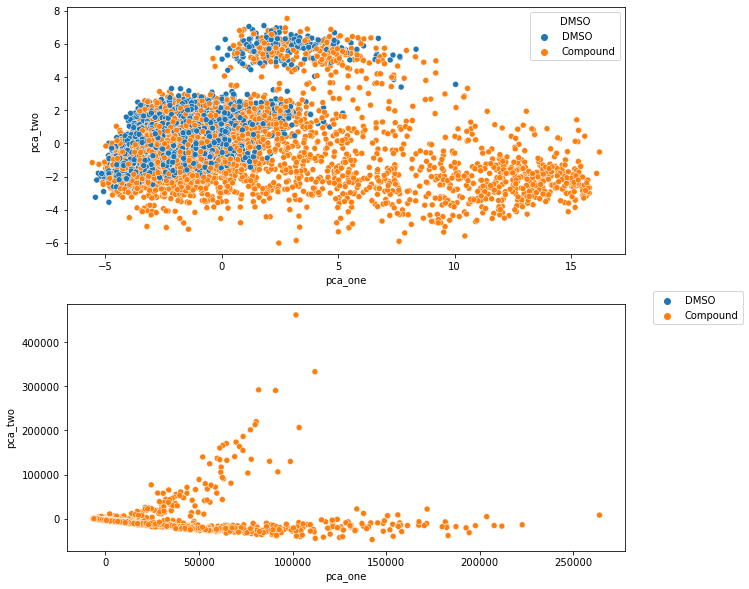

In [71]:
sphere['DMSO'] = sphere.Metadata_broad_sample.apply(is_dmso)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sphere[features].values)
sphere['pca_one'] = pca_result[:,0]
sphere['pca_two'] = pca_result[:,1]

fig, ax =plt.subplots(2,1, figsize=(10,10))
gfg = sns.scatterplot(data=sphere, x="pca_one", y='pca_two', hue='DMSO', sizes=3, ax=ax[1])
sns.scatterplot(data=df, x="pca_one", y='pca_two', hue='DMSO', sizes=3, ax=ax[0])
plt.style.use({'figure.facecolor':'white'})
plt.setp(gfg.get_legend().get_texts(), fontsize='5')
plt.legend(bbox_to_anchor=(1.05, 1.05), loc=2, borderaxespad=0.)